In [43]:
import warnings
warnings.filterwarnings('ignore')
import torch, torch.nn as nn, torch.nn.functional as F, torch.autograd as autograd, torch.optim as optim
import numpy as np, numpy.random as npr, matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from time import time
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

In [60]:
error_sigma = 1e-1
nobs = 1_000
xtrue = npr.randn(nobs, 1)
ytrue = np.zeros((nobs,3))
ytrue[:,0] = list(abs(xtrue)*np.cos(1.5*xtrue))
ytrue[:,1] = list(abs(xtrue)*np.sin(xtrue))
ytrue[:,2] = list(abs(xtrue)*np.sin(2*xtrue))
ytrue = 3*ytrue + npr.randn(*np.shape(ytrue))*error_sigma

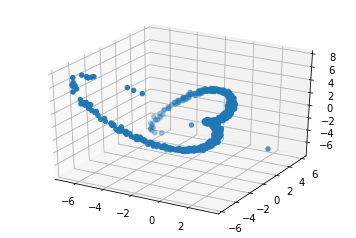

In [61]:
ax = plt.axes(projection='3d')
ax.scatter(ytrue[:,0], ytrue[:,1], ytrue[:,2])

In [74]:
mb_size = 10
Z_dim = 3
X_dim = np.shape(ytrue)[1]
h_dim = 100
c = 0
lr = 1e-3

In [75]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1/np.sqrt(in_dim/2)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [76]:
# =============================== Q(z|X) ======================================
# ============================== Encoding ===================================== 

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(X):
    h = F.tanh(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var/2) * eps

In [77]:
# =============================== P(X|z) ======================================
# ============================== Decoding ===================================== 

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

def P(z):
    h = F.tanh(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = h @ Whx + bhx.repeat(h.size(0), 1)
    return X

In [78]:
np.shape(ytrue)

(1000, 3)

In [79]:
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

T = 100_000
samples = torch.zeros(T, np.shape(ytrue)[1])
start = time()
for it in range(T) :
    mb = npr.choice(nobs,mb_size,replace=False)
    X = Variable(torch.from_numpy(ytrue[mb])).float()

    # Forward
    z_mu, z_var = Q(X)
    z = sample_z(z_mu, z_var)
    X_sample = P(z)
    
    samples[it] = X_sample[npr.choice(np.shape(X_sample)[0])]

    # Loss
#     recon_loss = F.binary_cross_entropy(X_sample, X, reduction='sum')/mb_size
    recon_loss = nn.MSELoss()(X_sample, X)
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
    loss = recon_loss + kl_loss

    loss.backward()
    solver.step()

    # Housekeeping
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

    # Print every now and then
    if (it+1) % (T/10) == 0:
        print("Iter: %d; loss: %.2f; time: %.1f sec" % (it+1, loss.data, time()-start))

Iter: 10000; loss: 2.74; time: 9.4 sec
Iter: 20000; loss: 2.73; time: 19.3 sec
Iter: 30000; loss: 1.77; time: 29.2 sec
Iter: 40000; loss: 2.08; time: 38.9 sec
Iter: 50000; loss: 1.81; time: 48.4 sec
Iter: 60000; loss: 2.39; time: 57.7 sec
Iter: 70000; loss: 1.30; time: 67.2 sec
Iter: 80000; loss: 2.00; time: 76.5 sec
Iter: 90000; loss: 2.43; time: 85.9 sec
Iter: 100000; loss: 2.02; time: 95.2 sec


In [80]:
samples = samples.data.numpy()

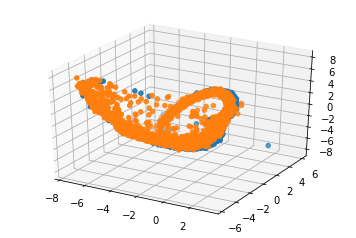

In [81]:
fig = plt.figure()
plt.subplot(121)
ax = plt.axes(projection='3d')
ax.scatter(ytrue[:,0], ytrue[:,1], ytrue[:,2])

ax.scatter(samples[90_000::,0], samples[90_000::,1], samples[90_000::,2])